In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
def create_circular_data(N=1000, radius_gap=1.0):
    """
    Creates two concentric circles:
      - Class 0: points in circle around origin with radius ~ 3
      - Class 1: points in circle around origin with radius ~ 3 + radius_gap
    """
    np.random.seed(42)
    N_half = N // 2
    
    # Class 0
    r0 = 3.0 + 0.2 * np.random.randn(N_half)  # around radius 3
    theta0 = 2 * np.pi * np.random.rand(N_half)
    X0 = np.column_stack((r0 * np.cos(theta0), r0 * np.sin(theta0)))
    y0 = np.zeros((N_half, 1))
    
    # Class 1
    r1 = (3.0 + radius_gap) + 0.2 * np.random.randn(N_half)
    theta1 = 2 * np.pi * np.random.rand(N_half)
    X1 = np.column_stack((r1 * np.cos(theta1), r1 * np.sin(theta1)))
    y1 = np.ones((N_half, 1))
    
    # Combine
    X = np.vstack([X0, X1])
    y = np.vstack([y0, y1])
    
    # Shuffle
    idx = np.arange(N)
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    
    return X, y

In [3]:
def relu(Z):
    return np.maximum(0, Z)

def relu_deriv(Z):
    return (Z > 0).astype(float)

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def forward_pass(X, W1, b1, W2, b2):
    """
    X: shape (N, 2)
    W1: shape (2, H)
    b1: shape (H,)
    W2: shape (H, 1)
    b2: shape (1,)
    
    Returns (Z1, A1, Z2, Y_pred)
    """
    Z1 = X.dot(W1) + b1  # (N, H)
    A1 = relu(Z1)        # (N, H)
    Z2 = A1.dot(W2) + b2 # (N, 1)
    Y_pred = sigmoid(Z2) # (N, 1)
    return Z1, A1, Z2, Y_pred

def binary_cross_entropy(Y_true, Y_pred):
    eps = 1e-10
    Y_pred = np.clip(Y_pred, eps, 1 - eps)
    N = Y_true.shape[0]
    loss = -1/N * np.sum(Y_true * np.log(Y_pred) + (1 - Y_true)*np.log(1 - Y_pred))
    return loss

def backward_pass(X, Y, Z1, A1, Z2, Y_pred, W1, b1, W2, b2):
    """
    X: (N, 2)
    Y: (N, 1)
    Z1, A1, Z2, Y_pred from forward pass
    W1, W2, b1, b2 are parameters for reference
    Returns gradients: dW1, db1, dW2, db2
    """
    N = X.shape[0]
    
    # Output layer error
    dZ2 = (Y_pred - Y)  # (N, 1), derivative of cross-entropy w.r.t. Z2
    
    # Grad w.r.t. W2, b2
    dW2 = (A1.T).dot(dZ2) / N  # shape (H, 1)
    db2 = np.sum(dZ2, axis=0) / N  # shape (1,)
    
    # Hidden layer error
    dA1 = dZ2.dot(W2.T)  # (N, H)
    dZ1 = dA1 * relu_deriv(Z1)  # apply derivative of ReLU
    
    # Grad w.r.t. W1, b1
    dW1 = (X.T).dot(dZ1) / N  # shape (2, H)
    db1 = np.sum(dZ1, axis=0) / N  # shape (H,)
    
    return dW1, db1, dW2, db2

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr=0.01):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2


In [4]:
def train(X, Y, H=10, lr=0.01, epochs=100):
    """
    2-layer MLP training with a single hidden layer of size H.
    Returns a history of parameters + losses at each step.
    """
    # Initialize parameters
    np.random.seed(0)
    W1 = 0.01 * np.random.randn(2, H)
    b1 = np.zeros(H)
    W2 = 0.01 * np.random.randn(H, 1)
    b2 = np.zeros(1)

    history = []
    
    for step_i in range(epochs):
        # 1. Forward
        Z1, A1, Z2, Y_pred = forward_pass(X, W1, b1, W2, b2)
        loss = binary_cross_entropy(Y, Y_pred)
        
        # 2. Store current state
        # We'll store *copies* of parameters so we can animate them
        history.append((
            W1.copy(), b1.copy(), W2.copy(), b2.copy(), loss
        ))
        
        # 3. Backward
        dW1, db1, dW2, db2 = backward_pass(X, Y, Z1, A1, Z2, Y_pred, W1, b1, W2, b2)
        
        # 4. Update
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr=lr)
    
    # Record the final state
    Z1, A1, Z2, Y_pred = forward_pass(X, W1, b1, W2, b2)
    final_loss = binary_cross_entropy(Y, Y_pred)
    history.append((W1.copy(), b1.copy(), W2.copy(), b2.copy(), final_loss))
    
    return history


In [ ]:
def animate_mlp_training(X, Y, history, interval=5, save_as=None):
    fig, ax = plt.subplots(figsize=(6,6))
    
    # Scatter the points
    ax.scatter(X[Y[:,0]==0,0], X[Y[:,0]==0,1], c='blue', label='Class 0')
    ax.scatter(X[Y[:,0]==1,0], X[Y[:,0]==1,1], c='red',  label='Class 1')
    ax.legend()
    ax.set_title("MLP Decision Boundary")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True)
    
    # Axis limits
    xlim = [X[:,0].min()-1, X[:,0].max()+1]
    ylim = [X[:,1].min()-1, X[:,1].max()+1]
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # For contour boundary
    contour_line = None

    def update(frame):
        nonlocal contour_line
        # Clear old contour if exists
        if contour_line is not None:
            for c in contour_line.collections:
                c.remove()

        W1, b1, W2, b2, loss = history[frame]
        ax.set_title(f"Step {frame+1}/{len(history)}, Loss={loss:.4f}")
        
        # Re-plot the contour
        x_vals = np.linspace(xlim[0], xlim[1], 100)
        y_vals = np.linspace(ylim[0], ylim[1], 100)
        xx, yy = np.meshgrid(x_vals, y_vals)
        
        grid_points = np.column_stack((xx.ravel(), yy.ravel()))
        _, _, _, pred = forward_pass(grid_points, W1, b1, W2, b2)
        zz = pred.reshape(xx.shape)
        
        # Only contour at p=0.5
        contour_line = ax.contour(xx, yy, zz, levels=[0.5], colors='green')
        return contour_line.collections
    
    anim = FuncAnimation(
        fig, update, 
        frames=len(history),
        interval=interval,
        blit=False
    )
    
    if save_as is not None:
        anim.save(save_as, writer='ffmpeg', fps=5)
    
    return anim

def plot_decision_boundary(X, Y, W1, b1, W2, b2, filename="mlp_circles.png"):
    """
    Plot the final MLP decision boundary for 2D data.
    """
    plt.figure(figsize=(6,6))
    # Scatter
    plt.scatter(X[Y[:,0]==0,0], X[Y[:,0]==0,1], c='blue', label='Class 0')
    plt.scatter(X[Y[:,0]==1,0], X[Y[:,0]==1,1], c='red',  label='Class 1')
    plt.legend()
    plt.title("MLP Decision Boundary on Circular Data")
    plt.grid(True)

    # Mesh for boundary
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    _, _, _, pred = forward_pass(grid, W1, b1, W2, b2)
    pred = pred.reshape(xx.shape)

    # Contour at probability=0.5
    # cs = plt.contour(xx, yy, pred, levels=[0.5], colors='green', linewidths=2)
    # cs.collections[0].set_label("Boundary p=0.5")

    plt.savefig(filename)
    print(f"Saved figure to {filename}")
    plt.show()

X shape: (500, 2) Y shape: (500, 1)
Training complete. Total steps recorded: 1001
Saved figure to mlp_final_bound.png


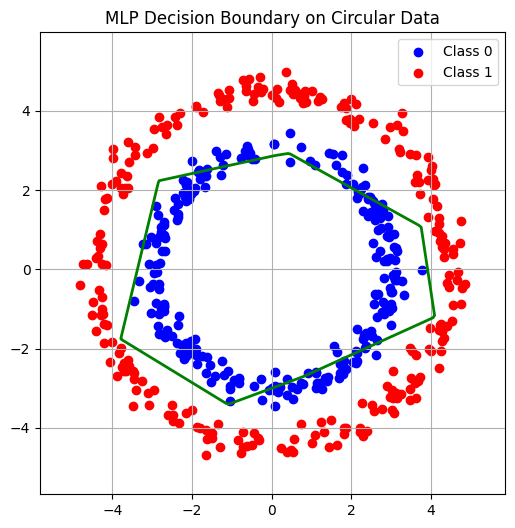

In [9]:
X, Y = create_circular_data(N=500, radius_gap=1.5)
print("X shape:", X.shape, "Y shape:", Y.shape)

history = train(
    X, Y, 
    H=10,        
    lr=0.05,     
    epochs=1000    
)
print("Training complete. Total steps recorded:", len(history))
W1, b1, W2, b2, final_loss = history[-1]
plot_decision_boundary(X, Y, W1, b1, W2, b2, filename="mlp_final_bound.png")

/tmp/ipykernel_47213/3729666243.py:43: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  return contour_line.collections
/tmp/ipykernel_47213/3729666243.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in contour_line.collections:


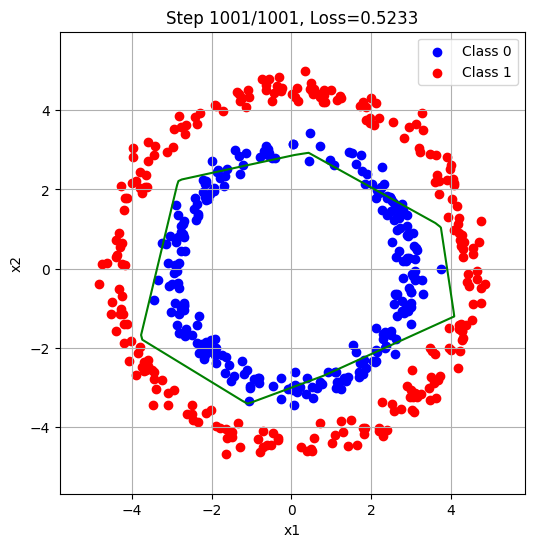

In [10]:
anim = animate_mlp_training(X, Y, history, interval=1, save_as="mlp.gif")
plt.show()